In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)
    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)
    
    return combined_annotations

In [9]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

In [10]:
# Ground Truth CSV
PATH = "../Data/"
gt_csv = PATH + "Dataset/CSVs/test_with_bg.csv"

# Read the Ground Truth CSV
gt_df = pd.read_csv(gt_csv)
print("Número de Ground Truths: ", len(gt_df))

Número de Ground Truths:  542


In [11]:
gt_df = group_consecutive_annotations_gt(gt_df)
gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
print("Número de Ground Truths agrupados: ", len(gt_df))

Número de Ground Truths agrupados:  403


In [12]:
# Función para convertir la puntuación de confianza en puntuación logit
def confidence_to_logit(confidence_score):
    # Evitar división por cero y logaritmo de cero
    confidence_score = np.clip(confidence_score, 1e-10, 1 - 1e-10)
    logit_score = np.log(confidence_score / (1 - confidence_score))
    return logit_score

# Función para convertir la puntuación logit en probabilidad
def logit_to_probability(logit_score):
    probability = 1 / (1 + np.exp(-logit_score))
    return probability

# Función para convertir la puntuación de confianza en probabilidad
def confidence_to_probability(confidence_score, sensitivity=1.0):
    probability = 1 / (1 + np.exp(-confidence_score / sensitivity))
    return probability

def confidence_to_logit_single(confidence_score):
    # Ensure the confidence score is within the valid range (0, 1)
    confidence_score = max(min(confidence_score, 1 - 1e-7), 1e-7)
    logit = np.log(confidence_score / (1 - confidence_score))
    return logit

def logit_to_confidence(logit):
    confidence = 1 / (1 + np.exp(-logit))
    return confidence

In [49]:
def evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name="", probability_correct_prediction=None, from_logit=False, confidence_score=0):
    # Leer el archivo CSV con anotaciones
    annotations_df = pd.read_csv(gt_annotations_file)
    annotations_df = group_consecutive_annotations_gt(annotations_df)
    annotations_df = pd.DataFrame(annotations_df)  # Convert list dict to DataFrame

    # Listar archivos de predicciones
    prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')
    number_of_predictions = len(prediction_files)
    print(f"Number of predictions: {number_of_predictions}")
    print(f"Number of annotations: {len(annotations_df)}")

    # Initialize an empty list to store prediction data
    predictions_data = []

    # Convert prediction files into a list of dictionaries with basename, start_time, end_time, and score
    for prediction in prediction_files:
        parts = prediction.split('_')
        score = float(parts[-1].split('.W')[0])

        if confidence_score is not None:
            if score > confidence_score:
                basename = '_'.join(parts[:3])
                start_time = parts[-3]
                end_time = parts[-2]

                predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time, 'score': score})

    # Convert the list of dictionaries into a DataFrame
    predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time', 'score'])

    # Convertir las puntuaciones de confianza a puntuaciones logit
    # predictions_df['probability'] = predictions_df['score'].apply(lambda x: confidence_to_probability(x, sensitivity=1))
    if from_logit:
        predictions_df['score'] = predictions_df['score'].apply(lambda x: confidence_to_logit_single(x))

    # Inicializar contadores y listas
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    fp_predictions = []
    fn_predictions = []

    # change annotations_df path to basename
    annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

    # Identificar anotaciones "No audio"
    no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

    # Evaluar predicciones en segmentos "No audio"
    if not no_audio_annotations.empty:
        for _, row in no_audio_annotations.iterrows():
            if row['basename'] in predictions_df['basename'].values:
                FP += len(predictions_df[predictions_df['basename'] == row['basename']])
                for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                    filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                    fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
            else:
                TN += len(predictions_df[predictions_df['basename'] == row['basename']])

    # Eliminar anotaciones "No audio" del DataFrame
    annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

    # Evaluar predicciones
    correct_predictions = []
    for _, prediction in predictions_df.iterrows():
        matched = False
        for _, row in annotations_df.iterrows():
            annotation_interval = [row['start_time'], row['end_time']]
            prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
            iou = calculate_iou(prediction_interval, annotation_interval)
            if iou >= iou_threshold and prediction['basename'] == row['basename']:
                TP += 1
                correct_predictions.append({'score': prediction['score'], 'correct': 1})
                matched = True
                break
        if not matched:
            FN += 1
            correct_predictions.append({'score': prediction['score'], 'correct': 0})
            filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
            fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})

    # Convertir listas a DataFrames
    #fp_df = pd.DataFrame(fp_predictions)
    #fn_df = pd.DataFrame(fn_predictions)
    correct_predictions_df = pd.DataFrame(correct_predictions)

    # Ajustar modelo de regresión logística
    X = correct_predictions_df[['score']]
    y = correct_predictions_df['correct']
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    # Predicciones de probabilidad
    X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='black', zorder=20)
    plt.plot(X_test, y_prob, color='C0', linewidth=3)

    # Plot red line if probability_correct_prediction is specified
    if probability_correct_prediction is not None:
        # Solve for score where the model predicts the specified probability
        # Temporary fix to avoid division by zero error
        aux_val = log_reg.coef_[0]
        if aux_val == 0:
            aux_val = 1e-10 # Avoid division by zero
        score_at_probability = (np.log(probability_correct_prediction / (1 - probability_correct_prediction)) - log_reg.intercept_) / (aux_val)
        plt.axvline(x=score_at_probability, color='C1', linestyle='--')  # Vertical line
        plt.axhline(y=probability_correct_prediction, color='C1', linestyle='--')  # Horizontal line
        plt.text(score_at_probability, 0.5, f'{score_at_probability[0]:.2f}', color='C1')

    if not from_logit:
        plt.xlabel('Prediction Score')
    else:
        plt.xlabel('Logit Score')
    plt.ylabel('Probability of Correct Prediction')
    plt.title(f'Logistic Regression Model\n{model_name}')
    plt.show()

    # Plot confusion matrix
    cm_general = np.array([[TP, FN], [FP, TN]])
    disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Bird', 'Background'])
    plt.figure(figsize=(8, 6))
    disp_general.plot(cmap='Blues')
    plt.title('Confusion Matrix (General)')
    plt.show()


    # Normalizar la matriz de confusión
    cm_general_normalized = cm_general.astype('float') / cm_general.sum(axis=1)[:, np.newaxis]

    # Asegurar que el valor mínimo sea 0
    cm_general_normalized = np.nan_to_num(cm_general_normalized)

    # Crear el display de la matriz de confusión normalizada
    disp_general_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_general_normalized, display_labels=['Positive', 'Negative'])

    # Configurar la figura
    plt.figure(figsize=(8, 6))

    # Dibujar la matriz de confusión con cmap 'Blues'
    disp_general_normalized.plot(cmap='Blues')
    plt.show()

    # Calcular métricas
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (TP + TN) / (TP + FP + FN + TN)

    # Print metrics
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1_score:.2f}')

In [45]:
def evaluate_predictions_extra(gt_annotations_file, experiment, iou_threshold, model_name="", probability_correct_prediction=None, from_logit=False, confidence_score=0):
    # Leer el archivo CSV con anotaciones
    annotations_df = pd.read_csv(gt_annotations_file)
    annotations_df = group_consecutive_annotations_gt(annotations_df)
    annotations_df = pd.DataFrame(annotations_df)  # Convert list dict to DataFrame

    # Listar archivos de predicciones
    prediction_files = os.listdir(f'../BirdNET/Audios/{experiment}')
    number_of_predictions = len(prediction_files)
    print(f"Number of predictions: {number_of_predictions}")
    print(f"Number of annotations: {len(annotations_df)}")

    # Initialize an empty list to store prediction data
    predictions_data = []

    # Convert prediction files into a list of dictionaries with basename, start_time, end_time, and score
    for prediction in prediction_files:
        parts = prediction.split('_')
        score = float(parts[-1].split('.W')[0])

        if confidence_score is not None:
            if score > confidence_score:
                basename = '_'.join(parts[:3])
                start_time = parts[-3]
                end_time = parts[-2]

                predictions_data.append({'basename': basename, 'start_time': start_time, 'end_time': end_time, 'score': score})

    # Convert the list of dictionaries into a DataFrame
    predictions_df = pd.DataFrame(predictions_data, columns=['basename', 'start_time', 'end_time', 'score'])

    # Convertir las puntuaciones de confianza a puntuaciones logit
    # predictions_df['probability'] = predictions_df['score'].apply(lambda x: confidence_to_probability(x, sensitivity=1))
    if from_logit:
        predictions_df['score'] = predictions_df['score'].apply(lambda x: confidence_to_logit_single(x))

    # Inicializar contadores y listas
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    fp_predictions = []
    fn_predictions = []

    # change annotations_df path to basename
    annotations_df['basename'] = annotations_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])

    # Identificar anotaciones "No audio"
    no_audio_annotations = annotations_df[annotations_df['specie'] == 'No audio']

    # Evaluar predicciones en segmentos "No audio"
    if not no_audio_annotations.empty:
        for _, row in no_audio_annotations.iterrows():
            if row['basename'] in predictions_df['basename'].values:
                FP += len(predictions_df[predictions_df['basename'] == row['basename']])
                for _, prediction in predictions_df[predictions_df['basename'] == row['basename']].iterrows():
                    filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
                    fp_predictions.append({'file': filename, 'reason': 'Predicted audio in no-audio segment'})
            else:
                TN += len(predictions_df[predictions_df['basename'] == row['basename']])

    # Eliminar anotaciones "No audio" del DataFrame
    annotations_df = annotations_df[annotations_df['specie'] != 'No audio']

    # Evaluar predicciones
    correct_predictions = []
    for _, prediction in predictions_df.iterrows():
        matched = False
        for _, row in annotations_df.iterrows():
            annotation_interval = [row['start_time'], row['end_time']]
            prediction_interval = [float(prediction['start_time']), float(prediction['end_time'])]
            iou = calculate_iou(prediction_interval, annotation_interval)
            if iou >= iou_threshold and prediction['basename'] == row['basename']:
                TP += 1
                correct_predictions.append({'score': prediction['score'], 'correct': 1})
                matched = True
                break
        if not matched:
            FN += 1
            correct_predictions.append({'score': prediction['score'], 'correct': 0})
            filename = str(prediction['basename'] + "_" + str(prediction["start_time"]) + "_" + str(prediction["end_time"]))
            fn_predictions.append({'file': filename, 'reason': 'No matching annotation found'})

    # Convertir listas a DataFrames
    #fp_df = pd.DataFrame(fp_predictions)
    #fn_df = pd.DataFrame(fn_predictions)
    correct_predictions_df = pd.DataFrame(correct_predictions)

    # Ajustar modelo de regresión logística
    X = correct_predictions_df[['score']]
    y = correct_predictions_df['correct']
    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    # Predicciones de probabilidad
    X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='black', zorder=20)
    plt.plot(X_test, y_prob, color='C0', linewidth=3)

    # Plot red line if probability_correct_prediction is specified
    if probability_correct_prediction is not None:
        # Solve for score where the model predicts the specified probability
        score_at_probability = (np.log(probability_correct_prediction / (1 - probability_correct_prediction)) - log_reg.intercept_) / log_reg.coef_[0]
        # Calculate percentage of true positives lost
        true_positives_lost = correct_predictions_df[(correct_predictions_df['score'] < score_at_probability[0]) & (correct_predictions_df['correct'] == 1)].shape[0] / TP * 100
        print(f"Percentage of True Positives lost at {probability_correct_prediction*100:.2f}% detection probability: {true_positives_lost:.2f}%")
        # Calculate confidence value
        if from_logit:
            confidence_value = logit_to_confidence(score_at_probability[0])
        else:
            confidence_value = score_at_probability[0]
        print(f"Confidence value for {probability_correct_prediction*100:.2f}% detection probability: {confidence_value:.2f}")
        
        plt.axvline(x=score_at_probability, color='C1', linestyle='--')  # Vertical line
        plt.axhline(y=probability_correct_prediction, color='C1', linestyle='--')  # Horizontal line
        # plt.text(score_at_probability, 0.5, f'{score_at_probability[0]:.2f}', color='C1')
        plt.text(score_at_probability + 0.05, probability_correct_prediction + 0.02, f'Logit: {score_at_probability[0]:.2f}\nConfidence: {confidence_value:.2f}', color='C1')
        plt.figtext(0.5, -0.02, f'True Positives Lost: {true_positives_lost:.2f}%', ha='center', color='black')
        
    if not from_logit:
        plt.xlabel('Prediction Score')
    else:
        plt.xlabel('Logit Score')
    plt.ylabel('Probability of Correct Prediction')
    plt.title(f'Logistic Regression Model\n{model_name}')
    plt.show()

    # Plot confusion matrix
    # cm_general = np.array([[TP, FN], [FP, TN]])
    # disp_general = ConfusionMatrixDisplay(confusion_matrix=cm_general, display_labels=['Bird', 'Background'])
    # plt.figure(figsize=(8, 6))
    # disp_general.plot(cmap='Blues')
    # plt.title('Confusion Matrix (General)')
    # plt.show()


    # # Normalizar la matriz de confusión
    # cm_general_normalized = cm_general.astype('float') / cm_general.sum(axis=1)[:, np.newaxis]

    # # Asegurar que el valor mínimo sea 0
    # cm_general_normalized = np.nan_to_num(cm_general_normalized)

    # # Crear el display de la matriz de confusión normalizada
    # disp_general_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_general_normalized, display_labels=['Positive', 'Negative'])

    # # Configurar la figura
    # plt.figure(figsize=(8, 6))

    # # Dibujar la matriz de confusión con cmap 'Blues'
    # disp_general_normalized.plot(cmap='Blues')
    # plt.show()

    # # Calcular métricas
    # precision = TP / (TP + FP)
    # recall = TP / (TP + FN)
    # f1_score = 2 * precision * recall / (precision + recall)
    # accuracy = (TP + TN) / (TP + FP + FN + TN)

    # # Print metrics
    # print(f'Accuracy: {accuracy:.2f}')
    # print(f'Precision: {precision:.2f}')
    # print(f'Recall: {recall:.2f}')
    # print(f'F1 Score: {f1_score:.2f}')

Number of predictions: 24433
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


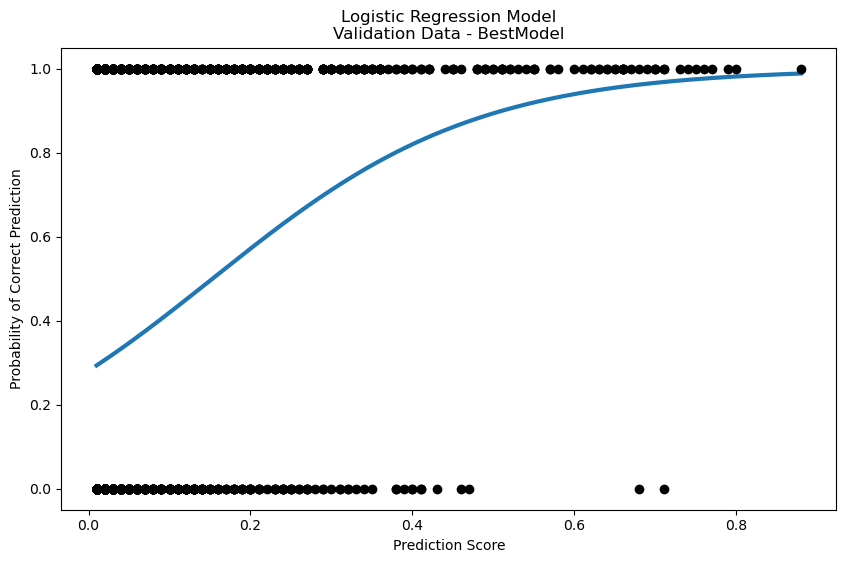

<Figure size 800x600 with 0 Axes>

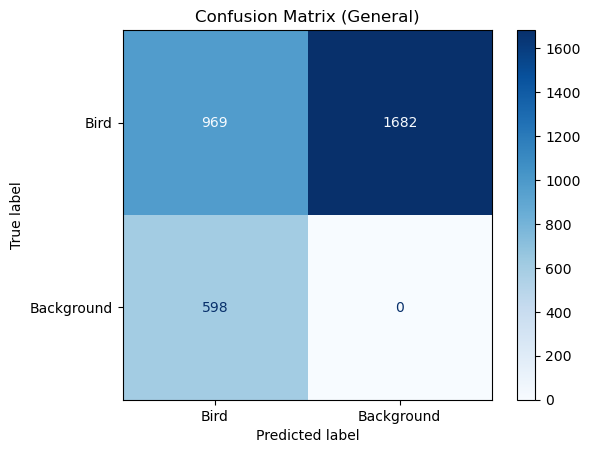

<Figure size 800x600 with 0 Axes>

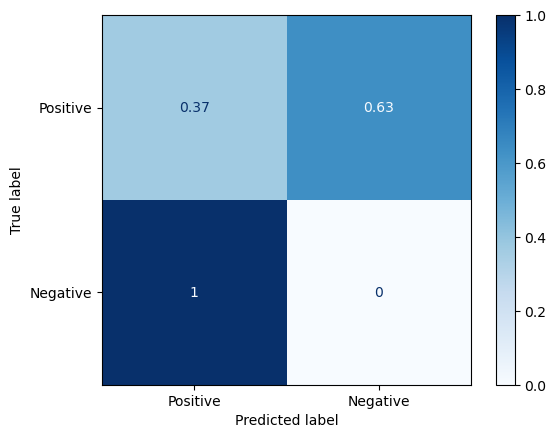

Accuracy: 0.30
Precision: 0.62
Recall: 0.37
F1 Score: 0.46


In [42]:
iou_threshold = 0.1
experiment = "predict_val_model12_conf0"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - BestModel"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 25896
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


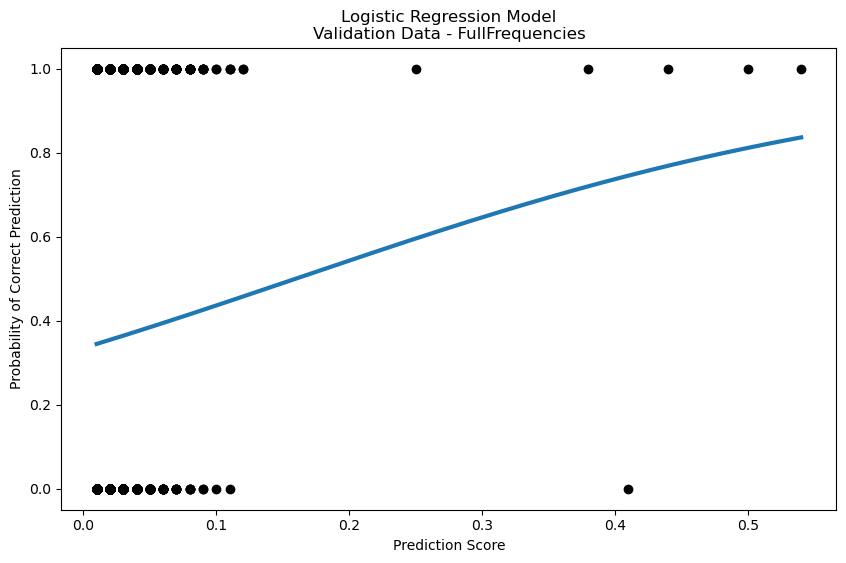

<Figure size 800x600 with 0 Axes>

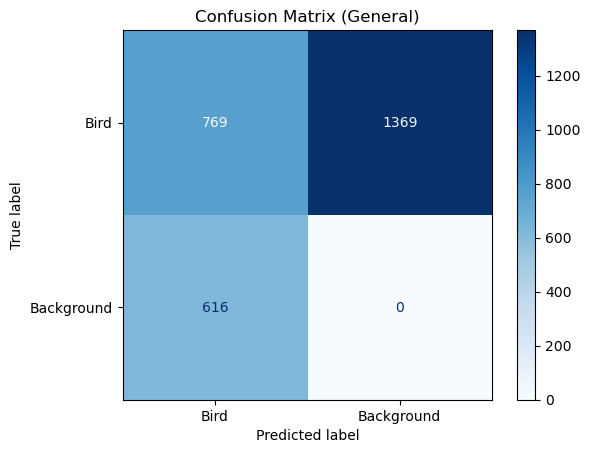

<Figure size 800x600 with 0 Axes>

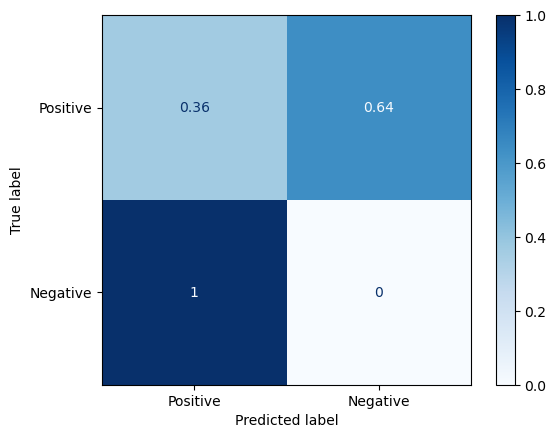

Accuracy: 0.28
Precision: 0.56
Recall: 0.36
F1 Score: 0.44


In [43]:
iou_threshold = 0.1
experiment = "predict_val_model11_conf0"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - FullFrequencies"
probability_correct_prediction = None

evaluate_predictions(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction)

Number of predictions: 447
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Percentage of True Positives lost at 60.00% detection probability: 22.08%
Confidence value for 60.00% detection probability: 0.15


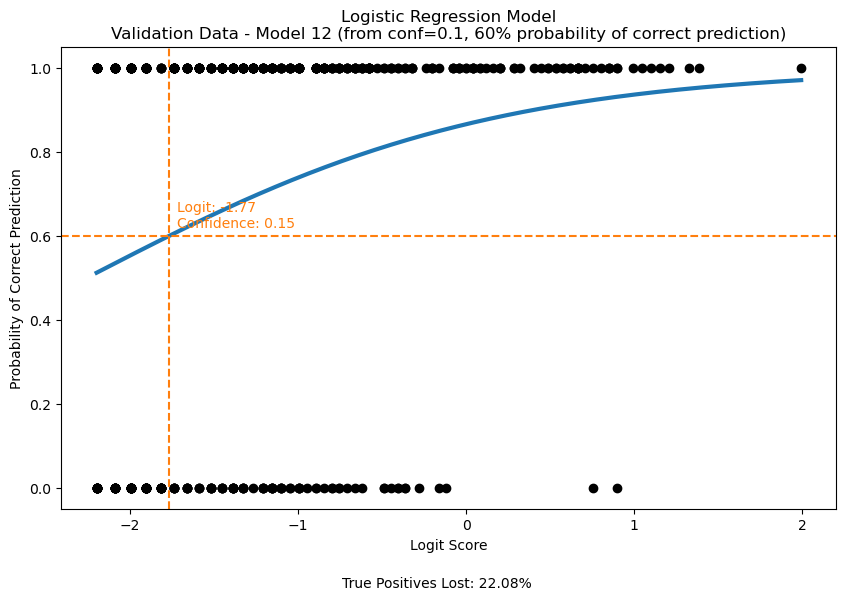

<Figure size 800x600 with 0 Axes>

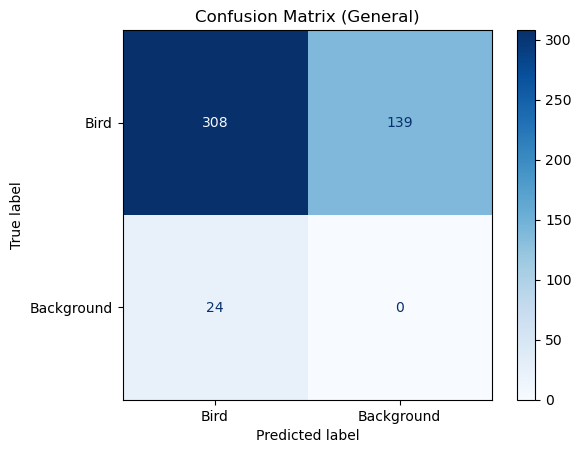

<Figure size 800x600 with 0 Axes>

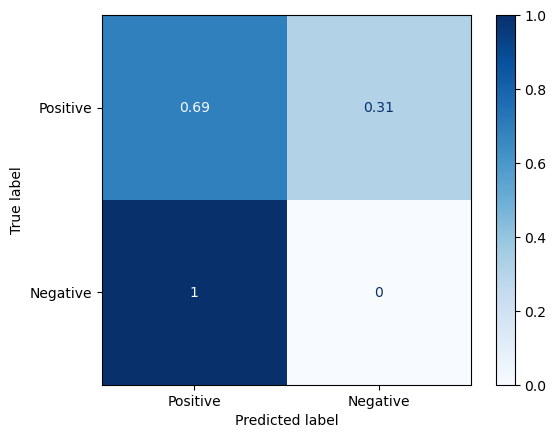

Accuracy: 0.65
Precision: 0.93
Recall: 0.69
F1 Score: 0.79


In [41]:
iou_threshold = 0.1
experiment = "predict__val_model12_conf01"
gt_annotations_file = f'../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name = "Validation Data - Model 12 (from conf=0.1, 60% probability of correct prediction)"
probability_correct_prediction = 0.6

evaluate_predictions_extra(gt_annotations_file, experiment, iou_threshold, model_name, probability_correct_prediction, from_logit=True)

Number of predictions: 447
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Percentage of True Positives lost at 40.00% detection probability: 0.00%
Confidence value for 40.00% detection probability: 0.06


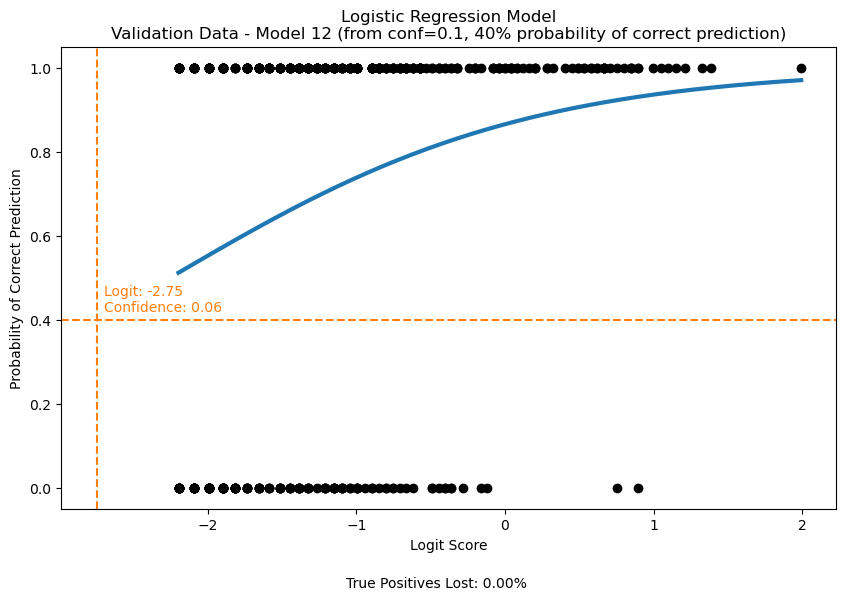

Number of predictions: 447
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Percentage of True Positives lost at 60.00% detection probability: 22.08%
Confidence value for 60.00% detection probability: 0.15


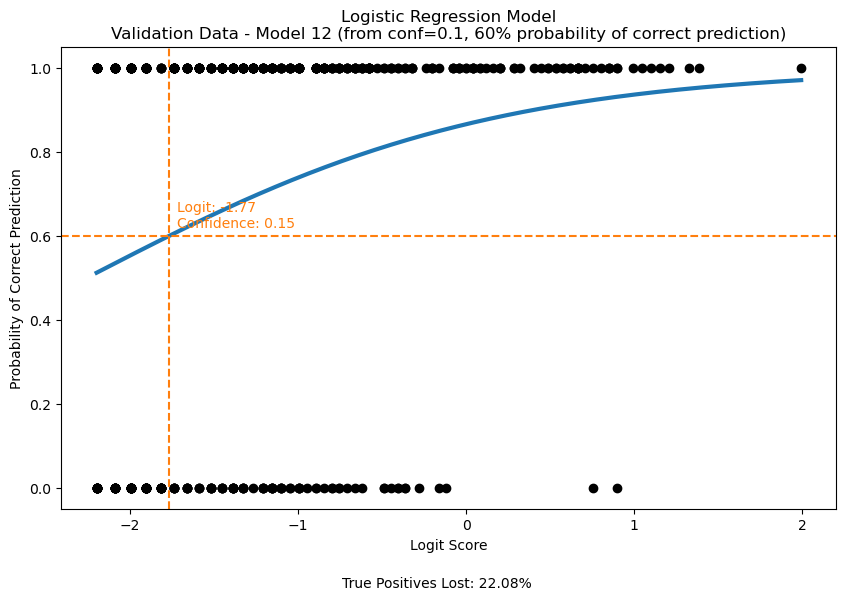

Number of predictions: 447
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Percentage of True Positives lost at 80.00% detection probability: 74.35%
Confidence value for 80.00% detection probability: 0.36


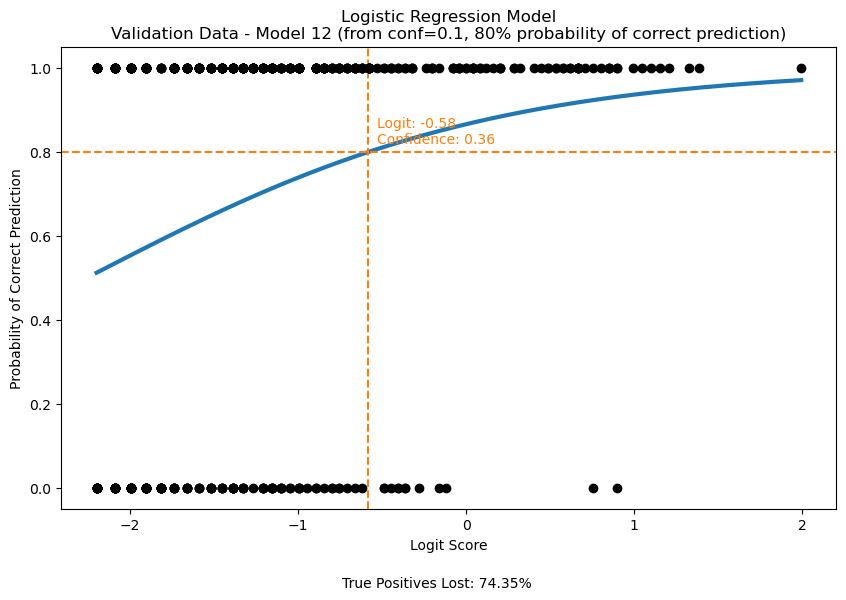

Number of predictions: 447
Number of annotations: 492


c:\Users\albam\anaconda3\envs\BIRDeep\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Percentage of True Positives lost at 95.00% detection probability: 99.03%
Confidence value for 95.00% detection probability: 0.79


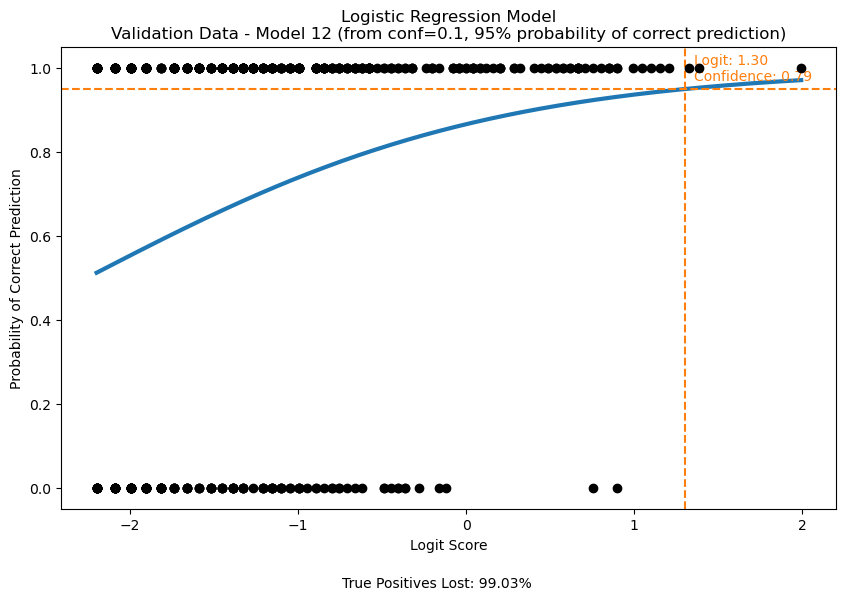

In [51]:
iou_threshold = 0.1
experiment = "predict__val_model12_conf01"
gt_annotations_file = '../BirdNET/Dataset/validation_with_augmented_bg.csv'
model_name_template = "Validation Data - Model 12 (from conf=0.1, {}% probability of correct prediction)"

# Lista de porcentajes de predicciones correctas
probabilities_correct_prediction = [0.4, 0.6, 0.8, 0.95]

for probability in probabilities_correct_prediction:
    # Actualizar el nombre del modelo para reflejar el porcentaje de predicción correcta actual
    model_name = model_name_template.format(int(probability * 100))
    
    # Llamar a la función evaluate_predictions_extra con el porcentaje de predicción correcta actual
    evaluate_predictions_extra(gt_annotations_file, experiment, iou_threshold, model_name, probability, from_logit=True)